In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.optimize

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/var/folders/pg/9b4jm_x17t9_7br0mxk3vcy00000gn/T/ipykernel_49380/2106068084.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
def load(path):
    samples = pd.read_csv(path)
    samples['observer_angle'] = np.rad2deg(samples['observer_angle'])
    return samples

In [21]:
samples_0 = load('samples/0.csv')
samples_mq_uniform = load('samples/mq_uniform.csv')
samples_mq_inv = load('samples/mq_inv.csv')
samples_bb = load('samples/black_body.csv')
samples_bb0 = load('samples/black_body_0.csv')

samples = pd.concat(
    [samples_mq_inv, samples_mq_uniform, samples_0],
    keys=[
r'$q \sim U(0.1, 10)$',
r'$q^{-1} \sim U(0.1, 10)$',
r'''$m_\text{giant} \sim U(0.6 M_\odot, 10 M_\odot)$, $m_\text{dwarf} \sim U(0.3 M_\odot, 1.44 M_\odot)$'''
    ],
    names=['model']
)

In [5]:
def get_max_point(samples):
    dist = scipy.stats.gaussian_kde([samples['mass_quotient_inv'], samples['observer_angle']])
    return scipy.optimize.minimize(lambda x: -dist(x), (0.7, 55)).x

In [6]:
# (deep, muted, bright, pastel, dark, colorblind)

In [7]:
sns.set_style('whitegrid')

In [8]:
sns.set_palette('bright')

In [9]:
len(samples)

38400

In [10]:
def i(q, m_dwarf = 1.44):
    sin = np.cbrt(0.322408 / m_dwarf * (1 + q)**2)
    sin = np.clip(sin, -1, 1)
    return np.rad2deg(np.arcsin(sin))

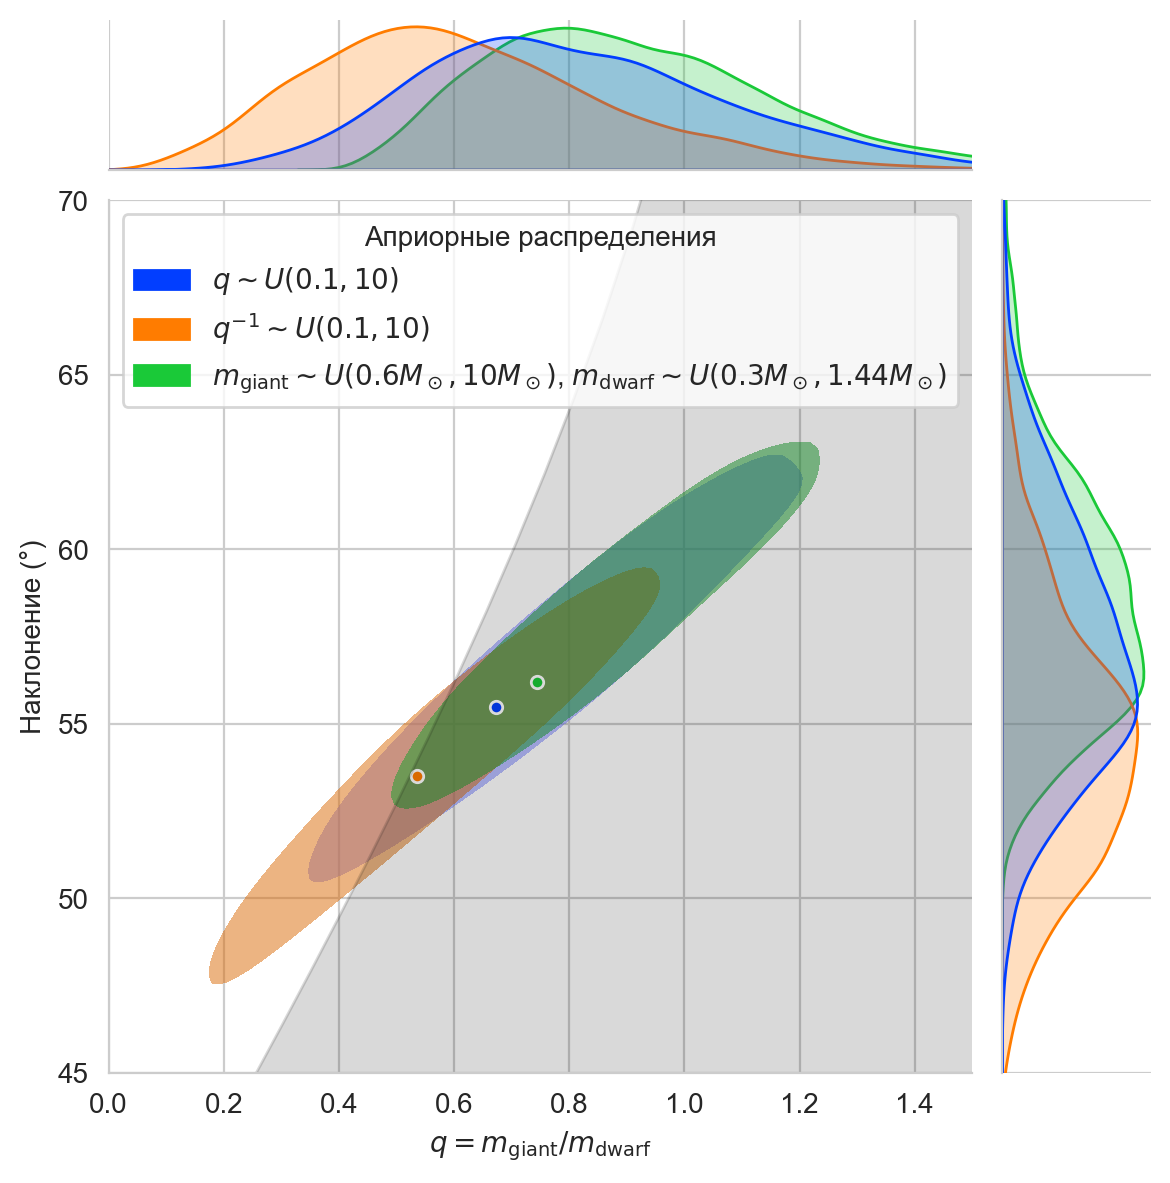

In [36]:
joint_grid = sns.jointplot(
    samples,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'fill': True, 'levels': [0.32, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

s = 20
joint_grid.ax_joint.scatter(*get_max_point(samples_mq_inv), edgecolors='white', s=s)
joint_grid.ax_joint.scatter(*get_max_point(samples_mq_uniform), edgecolors='white', s=s)
joint_grid.ax_joint.scatter(*get_max_point(samples_0), edgecolors='white', s=s)


joint_grid.ax_joint.legend_.set_title('Априорные распределения')
joint_grid.ax_joint.legend_.set_loc('upper center')
joint_grid.set_axis_labels(r'$q = m_\text{giant} / m_\text{dwarf}$', 'Наклонение (°)')
joint_grid.ax_joint.set_xlim(0, 1.5)
joint_grid.ax_joint.set_ylim(45, 70)


q_list = np.linspace(0, 5, 100)
joint_grid.ax_joint.fill_between(q_list, i(q_list), color='black', alpha=0.15)

In [37]:
joint_grid.savefig('tex/pic_drafts/biplot_different_q.pdf', facecolor='white')

In [13]:
[get_max_point(samples_mq_inv), get_max_point(samples_mq_uniform), get_max_point(samples_0)]

[array([ 0.67291903, 55.47301545]),
 array([ 0.53569601, 53.50013602]),
 array([ 0.74410904, 56.20278953])]

(42.0, 77.0)

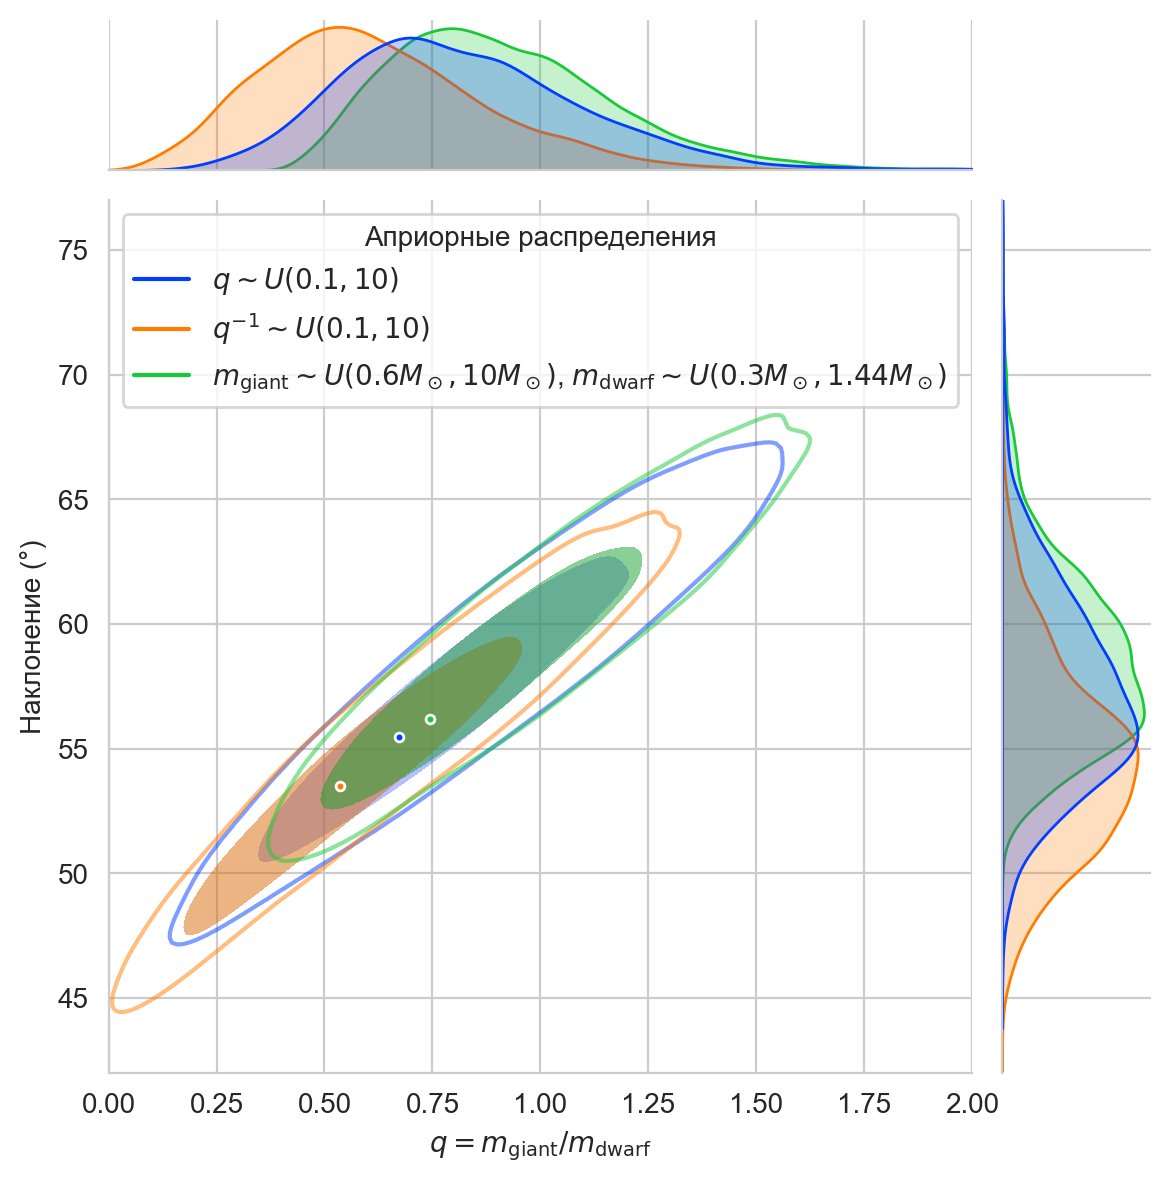

In [14]:
joint_grid = sns.jointplot(
    samples,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'fill': True, 'levels': [0.32, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

sns.kdeplot(
    samples,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    **{'levels': [0.05, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    ax=joint_grid.ax_joint
)

s = 10

joint_grid.ax_joint.scatter(*get_max_point(samples_mq_inv), edgecolors='white', s = s)
joint_grid.ax_joint.scatter(*get_max_point(samples_mq_uniform), edgecolors='white', s = s)
joint_grid.ax_joint.scatter(*get_max_point(samples_0), edgecolors='white', s = s)


joint_grid.ax_joint.legend_.set_title('Априорные распределения')
joint_grid.ax_joint.legend_.set_loc('upper center')
joint_grid.set_axis_labels(r'$q = m_\text{giant} / m_\text{dwarf}$', 'Наклонение (°)')
joint_grid.ax_joint.set_xlim(0, 2.0)
joint_grid.ax_joint.set_ylim(42, 77)

In [15]:
def get_true_max_point_0(samples):
    uniform_parameters = [
        'm_giant',
        'm_dwarf',
        'cos_i',
        'initial_phase',
        'offset[1]',
        'offset[2]',
        'log_σ_common[1]',
        'log_σ_common[2]'
    ]
    dist = scipy.stats.gaussian_kde(samples[uniform_parameters].values.T)
    result_array =  scipy.optimize.minimize(
        lambda x: -dist(x),
        dist.dataset.mean(axis=1)
    ).x
    answer = dict(zip(uniform_parameters, result_array))
    answer['mass_quotient_inv'] = answer['m_giant'] / answer['m_dwarf']
    answer['observer_angle'] = np.rad2deg(np.arccos(answer['cos_i']))
    return answer

get_true_max_point_0(samples_0)

{'m_giant': 0.8928691940866842,
 'm_dwarf': 1.2751130157894834,
 'cos_i': 0.5629221983881681,
 'initial_phase': -1.4415180264045138,
 'offset[1]': 46.69041094882011,
 'offset[2]': 48.89510617849503,
 'log_σ_common[1]': -3.762347842237094,
 'log_σ_common[2]': -3.6005428574015697,
 'mass_quotient_inv': 0.7002274959399314,
 'observer_angle': 55.741870888355244}

In [16]:
def get_true_max_point_mq_uniform(samples):
    uniform_parameters = [
        'mass_quotient',
        'cos_i',
        'initial_phase',
        'offset[1]',
        'offset[2]',
        'log_σ_common[1]',
        'log_σ_common[2]'
    ]
    dist = scipy.stats.gaussian_kde(samples[uniform_parameters].values.T)
    result_array = scipy.optimize.minimize(
        lambda x: -dist(x),
        dist.dataset.mean(axis=1)
    ).x
    answer = dict(zip(uniform_parameters, result_array))
    answer['mass_quotient_inv'] = 1 / answer['mass_quotient']
    answer['observer_angle'] = np.rad2deg(np.arccos(answer['cos_i']))
    return answer

get_true_max_point_mq_uniform(samples_mq_uniform)

{'mass_quotient': 1.8034286592234228,
 'cos_i': 0.5863737001754304,
 'initial_phase': -1.4342221234428705,
 'offset[1]': 46.69115220107926,
 'offset[2]': 48.896829726349495,
 'log_σ_common[1]': -3.7624314807934547,
 'log_σ_common[2]': -3.603787795013639,
 'mass_quotient_inv': 0.5544993392921966,
 'observer_angle': 54.09990497591256}

In [17]:
def get_true_max_point_mq_inv(samples):
    uniform_parameters = [
        'mass_quotient_inv',
        'cos_i',
        'initial_phase',
        'offset[1]',
        'offset[2]',
        'log_σ_common[1]',
        'log_σ_common[2]'
    ]
    dist = scipy.stats.gaussian_kde(samples[uniform_parameters].values.T)
    result_array = scipy.optimize.minimize(
        lambda x: -dist(x),
        dist.dataset.mean(axis=1)
    ).x
    answer = dict(zip(uniform_parameters, result_array))
    answer['observer_angle'] = np.rad2deg(np.arccos(answer['cos_i']))
    return answer

get_true_max_point_mq_inv(samples_mq_inv)

{'mass_quotient_inv': 0.714431797682888,
 'cos_i': 0.5632558581742567,
 'initial_phase': -1.4358774316364171,
 'offset[1]': 46.69046216890544,
 'offset[2]': 48.89529347471417,
 'log_σ_common[1]': -3.7684471931608545,
 'log_σ_common[2]': -3.6020473750206152,
 'observer_angle': 55.71873755725923}

In [18]:
samples_diff_L = pd.concat(
    [samples_mq_inv, samples_bb],
    keys=[
        'PHOENIX',
        'Black Body'
    ],
    names=['model']
)

(45.0, 72.0)

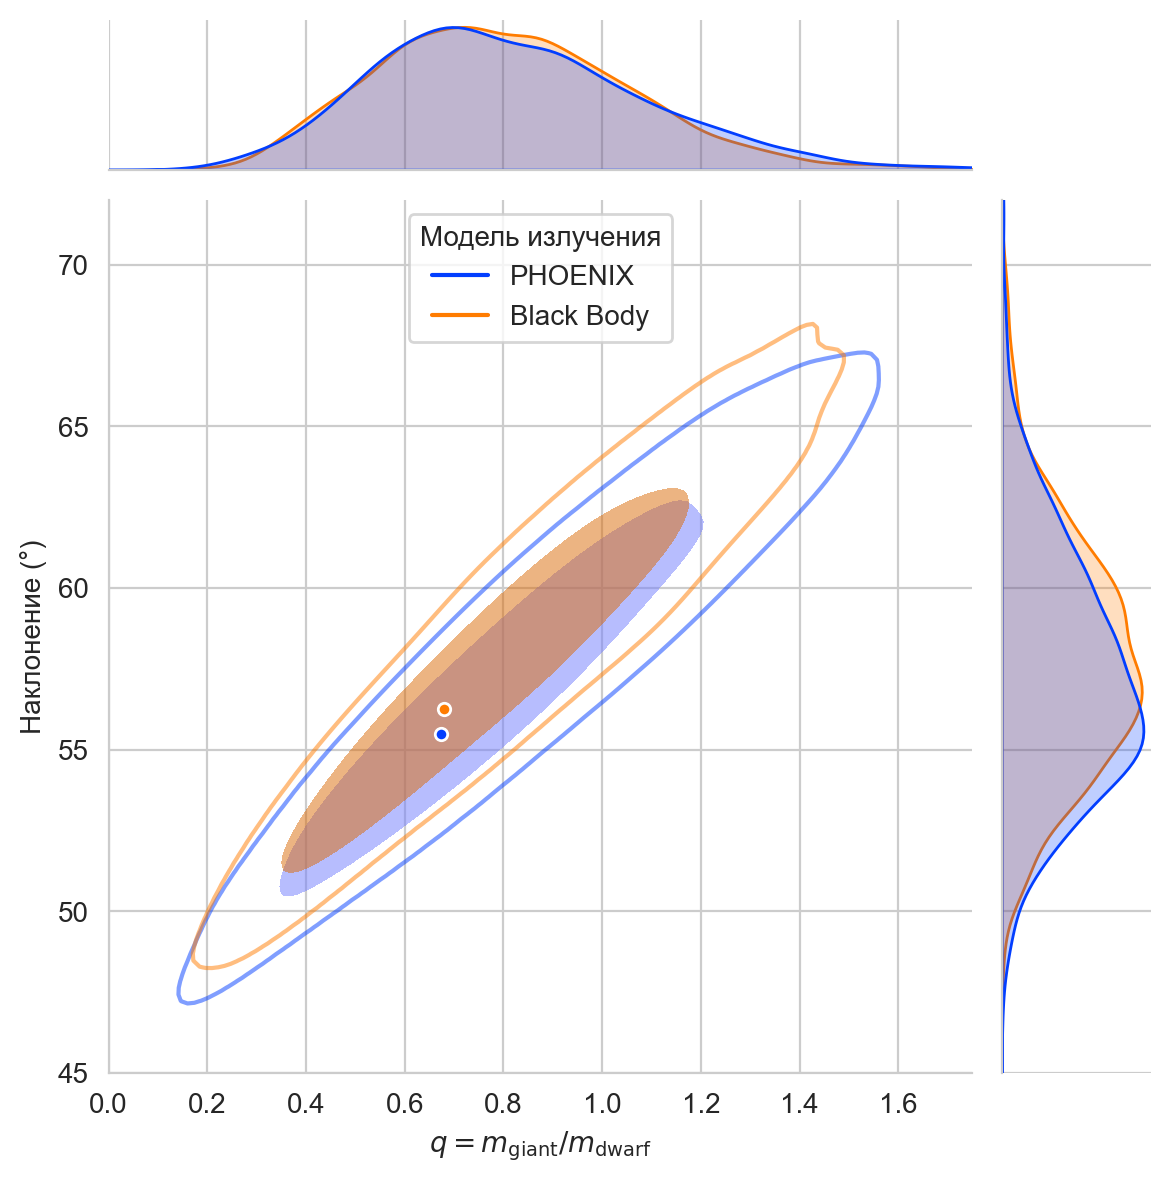

In [32]:
joint_grid = sns.jointplot(
    samples_diff_L,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'fill': True, 'levels': [0.32, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

sns.kdeplot(
    samples_diff_L,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    **{'levels': [0.05, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    ax=joint_grid.ax_joint
)

s = 20

joint_grid.ax_joint.scatter(*get_max_point(samples_mq_inv), edgecolors='white', s = s)
joint_grid.ax_joint.scatter(*get_max_point(samples_bb), edgecolors='white', s = s)

joint_grid.ax_joint.legend_.set_title('Модель излучения')
joint_grid.ax_joint.legend_.set_loc('upper center')
joint_grid.set_axis_labels(r'$q = m_\text{giant} / m_\text{dwarf}$', 'Наклонение (°)')
joint_grid.ax_joint.set_xlim(0, 1.75)
joint_grid.ax_joint.set_ylim(45, 72)

In [35]:
joint_grid.savefig('tex/pic_drafts/biplot_differerent_L.pdf', facecolor='white')

In [22]:
samples_diff_L0 = pd.concat(
    [samples_0, samples_bb0],
    keys=[
        'PHOENIX',
        'Black Body'
    ],
    names=['model']
)

(42.0, 77.0)

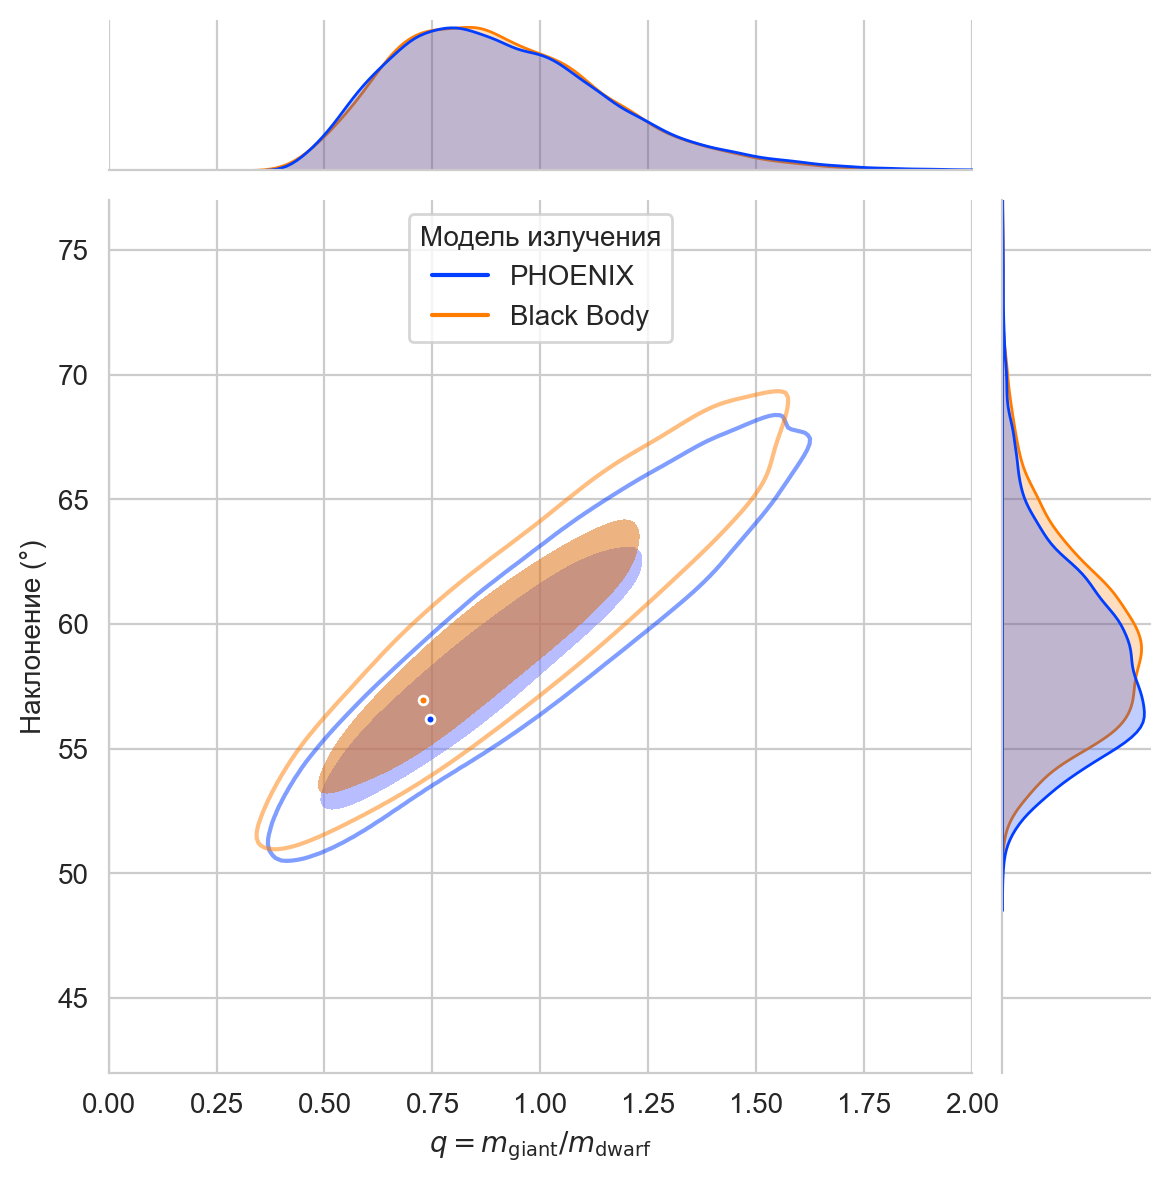

In [25]:
joint_grid = sns.jointplot(
    samples_diff_L0,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'fill': True, 'levels': [0.32, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

sns.kdeplot(
    samples_diff_L0,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    **{'levels': [0.05, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    ax=joint_grid.ax_joint
)

s = 10

joint_grid.ax_joint.scatter(*get_max_point(samples_0), edgecolors='white', s = s)
joint_grid.ax_joint.scatter(*get_max_point(samples_bb0), edgecolors='white', s = s)

joint_grid.ax_joint.legend_.set_title('Модель излучения')
joint_grid.ax_joint.legend_.set_loc('upper center')
joint_grid.set_axis_labels(r'$q = m_\text{giant} / m_\text{dwarf}$', 'Наклонение (°)')
joint_grid.ax_joint.set_xlim(0, 2.0)
joint_grid.ax_joint.set_ylim(42, 77)